# 1 DataLoader与Dataset
## 1.1 实例：人民币分类


$数据\begin{cases}
数据收集 \rightarrow Img, Label\\
数据划分 \rightarrow train, valid, test\\
数据读取 \rightarrow DataLoader \begin{cases}
    Sampler \rightarrow 生成Index\\
    DataSet \rightarrow 根据索引读取Img,Label
    \end{cases}\\
数据预处理 \rightarrow transforms
\end{cases}$

## DataLoader
### - otrch.utils.data.DataLoader
功能：构建可迭代的数据装载器
- dataset：Dataset类，决定数据从哪读取及如何读取
- batchsize：批大小
- num_works:是否多进程读取数据
- shuffle：每个epoch是否乱序
- drop_last: 当样本数不能被batchsize整除时，是否舍弃最后一批数据

`Epoch:`所有训练样本都已输入到模型中，称为一个Epoch\
`Iteration:`一批样本输入到模型中，称为一个Iteration\
`Batchsizse:`批大小，决定一个Epoch有多少个Iteration

### -torch.utils.data.Dataset
功能：Dataset抽象类，所有自定义的Dataset需要继承它，并且复写\
\_\_getitem\_\_()

```
getitem:
  接受一个索引，返回一个样本
```

$数据读取\begin{cases}
1. 读哪些数据?\\
2. 从哪读数据?\\
3. 怎么读数据?
\end{cases}
$

[Python标准库之os](https://blog.csdn.net/m0_46223009/article/details/128065092)
#### os.walk() 
以root, dirs, files的方式树形遍历路径，并把root, dirs, files三元组返回

$shutil模块\begin{cases}
1.复制文件或文件夹\begin{cases}
    1.1 shutil.copy(src, dst) \rightarrow 复制文件\\
    1.2 shutil.copytree(src, dst) \rightarrow 复制文件夹\\
    \end{cases}\\
2. 移动文件或文件夹 \Rightarrow shutil.move(src, dst) \rightarrow 移动文件或文件夹\\
3. 删除文件夹（不能删除文件）\Rightarrow shutil.rmtree(src) \rightarrow 删除文件夹\\
4. 创建和解压压缩包\begin{cases}
    4.1 zipobj.write() \rightarrow 创建一个压缩包\\
    4.2 zipobj.namelist() \rightarrow 读取压缩包中的文件信息\\
    4.3 zipobj.extract() \rightarrow 将压缩包的单个文件，解压出来\\
    4.4 zipobj.extractall() \rightarrow 将压缩包中的所有文件解压出来
    \end{cases}
\end{cases}$

---
#### 数据集划分

In [1]:
import os
import random
import shutil

def mkdir(new_dir):
    if not os.path.exists(new_dir):
        os.makedirs(new_dir) #可以递归创建多级目录

random.seed(1)

root_dir = os.getcwd()
# 读哪的数据
dataset_dir = os.path.join(root_dir, "data", "RMB_data")
split_dir = os.path.join(root_dir, "data", "rmb_split")
train_dir = os.path.join(split_dir, "train")
valid_dir = os.path.join(split_dir, "valid")
test_dir = os.path.join(split_dir, "test")


train_pct = 0.8
valid_pct = 0.1
test_pct = 0.1

for root, dirs, files in os.walk(dataset_dir):
    for sub_dir in dirs:
        imgs = os.listdir(os.path.join(root, sub_dir)) #listdir遍历文件夹所有文件并返回对应列表
        imgs = list(filter(lambda x: x.endswith('.jpg'), imgs))
        random.shuffle(imgs)
        img_count = len(imgs)

        # 前面已经打乱，之后枚举将每个文件放入对应文件夹几个
        train_point = int(img_count * train_pct)
        train_valid_point = int(img_count * (train_pct + valid_pct))

        # 判断放入哪个文件夹
        for i in range(img_count):
            if i <= train_point:
                out_dir = os.path.join(train_dir, sub_dir)
            elif i <= train_valid_point:
                out_dir = os.path.join(valid_dir, sub_dir)
            else:
                out_dir = os.path.join(test_dir, sub_dir)

            # 文件夹不存在则创建
            mkdir(out_dir)
            # 找出对应文件
            src_path = os.path.join(dataset_dir, sub_dir, imgs[i])
            target_path = os.path.join(out_dir, imgs[i])

            shutil.copy(src_path, target_path)

        print("class: {}, train: {}, valid: {}, test: {}".format(sub_dir, train_point, train_valid_point - train_point, img_count - train_valid_point))
        

class: 1, train: 80, valid: 10, test: 10
class: 100, train: 80, valid: 10, test: 10


---
#### 数据集读取

In [2]:
# 定义DataLoader类
from PIL import Image
from torch.utils.data import Dataset

random.seed(1)

label_name = {"1":0, "100": 1}

class RMBDataset(Dataset):
    # 构造Dataset主要要写的构造函数
    def __init__(self, data_dir, transform = None): 
        '''
        rmb面额分类任务Dataset
        :param data_dir：str, 数据集所在路径
        :param transform: torch.transform, 数据预处理
        '''
        self.label_name = {"1": 0, "100": 1}
        self.data_info = self.get_img_info(data_dir)
        self.transform = transform

    # 主要要写的，接受一个索引返回一个样本, 需要转换成RGB后的图片和标签
    def __getitem__(self, index): 
        path_img, label = self.data_info[index]
        img = Image.open(path_img).convert('RGB') # 0~255

        if self.transform is not None:
            img = self.transform(img)

        return img, label

    def __len__(self):
        return len(self.data_info)

    @staticmethod
    def get_img_info(data_dir):
        data_info = list()
        for root, dirs, _ in os.walk(data_dir):
            #遍历类别
            for sub_dir in dirs:
                img_names = os.listdir(os.path.join(root, sub_dir))
                img_names = list(filter(lambda x: x.endswith(".jpg"), img_names))

                #遍历图片
                for i in range(len(img_names)):
                    img_name = img_names[i]
                    path_img = os.path.join(root, sub_dir, img_name)
                    label = label_name[sub_dir]
                    data_info.append((path_img, int(label)))
                                     
        return data_info

---
#### 数据预处理

# 2 transforms
## torchvision.transforms: 常见的图像预处理方法
torchvision：计算机视觉工具包

提供的常见图像预处理方法：
- 数据中心化
- 数据标准化
- 缩放
- 裁剪
- 旋转
- 翻转
- 填充
- 噪声添加
- 灰度变换
- 线性变换
- 仿射变换
- 亮度、饱和度及对比度变换


### - transforms.Normalize
功能：逐channel的对图像进行标准化，得到0均值1方差的标准正态分布
output = (input - mean) / std
- mean: 各通道的均值
- std：各通道的标准差
- inplace：是否原地操作

数据增强：又称数据增广，数据扩增，它是对训练集进行变换，使训练集更丰富，从而让模型更具泛化能力

---
## 2.1 图像裁剪
### - transforms.CenterCrop
功能：从图像中心裁剪图片
- size：所需裁剪图片尺寸

### - transforms.RandomCrop
功能：从图片中随机裁剪出尺寸为size的图片
- size：所需裁剪图片尺寸
- padding：设置填充大小
    - 当为a时，上下左右均填充a个像素
    - 当为(a, b)时，上下填充b个像素，左右填充a个像素
    - 当为(a, b, c, d)时，左上右下分别填充a, b, c, d
- pad_if_need: 若图像小于设定size，则填充
- padding_mode:填充模式，有4中模式
    1. constant:像素值有fill设定
    2. edge：像素值由图像边缘决定
    3. reflect：镜像填充，最后一个像素不镜像，eg: [1, 2, 3, 4] --> [3, 2, 1, 2, 3, 4, 3, 2]
    4. symmetric: 镜像填充，最后一个像素镜像，eg: [1, 2, 3, 4] --> [2, 1, 1, 2, 3, 4, 4, 3]
- fill: constant时，设置填充的像素值

### - RandomResizedCrop
功能：随机大小、长宽比裁剪图片
- size：所需裁剪图片尺寸
- scale：随机裁剪面积比例，默认(0.08, 1)
- ratio: 随机长宽比，默认(3/4, 4/3)
- interpolation: 插值方法
    - PIL.Image.NEAREST 最紧邻方法
    - PIL.Image.BILNEAR 双线性插值
    - PIL.Image.BICUBIC

### - FiveCrop
功能：在图像的上下左右以及中心裁剪出尺寸为size的5张图片\
但是返回的元祖形式，不能直接使用

### - TenCrop
功能：在FiveCrop的基础上，对这5张图片进行平行或者垂直镜像获得10张图片
- size: 所需裁剪图片尺寸
- vertical_flip: 是否垂直翻转\
返回的是元祖形式


---
## 2.2 图像翻转
### - RandomHorizontalFlip
### - RandomVerticalFlip
功能：依概率水平（左右）或垂直（上下）翻转图片
- p: 翻转概率

### - Randomrotation
功能：随机旋转图片

- degrees: 旋转角度
  - 当为a时，在(-a, a)之间选择旋转角度
  - 当为(a, b)时， 在(a, b)之间选择旋转角度
- resample: 重采样方法
- expand：是否扩大图片，以保持原图信息
- center: 旋转点设置，默认中心旋转

---
## 2.3 其他方法
### - Pad
功能：对图片边缘进行填充
- padding: 设置填充大小
    - 当为a时，左上右下均填充a各像素
    - 当为(a, b)时，上下填充b各像素，左右填充a各像素
    - 当为(a, b, c, d)时，左，上，右，下分别填充a, b, c, d
- padding_mode: 填充模式，有4种模式，constant, edge、reflect和symmetric
- fill: 当为constant时，设置填充用的像素值

### - ColorJitter
功能：调整亮度、对比度、饱和度和色相
- brightness:亮度调整因子
    - 当为a时，从[max(0, 1 - a), 1 + a]中随机选择
    - 当为(a, b)时，从[a, b]中
- contrast：对比度参数，同brightness
- saturation：饱和度参数，同brightness
- hue：色相参数
    - 当为a时，从[-a, a]中选择参数，注：$0\leq a \leq 0.5$
    - 当为(a, b)时，从[a, b]中选择参数，注：$-0.5 \leq a \leq b \leq 0.5$

### - Crayscale
### - RandomGrayscale
功能：依概率将图片转换为灰度图
- num_output_channels:输出通道数只能设1或3
- p: 概率值，图像被转换为灰度图的概率

### - RandomAffine
功能：对图像进行放射变换，仿射变换是二维的线性变换，有五种基本原子变换构成，分别是旋转、平移、缩放、错切和翻转
- degrees:旋转角度设置
- translate：平移区间设置，如(a, b), a设置宽(width), b设置高(height)
    图像在宽维度平移的区间为 $-img_width * a < dx < img_width * a$
- scale: 缩放比例（以面积为单位）
- fill: 填充颜色设置
- shear:错切角度设置，有水平错切和垂直错切
    - 若为a，则仅在x轴错切，错切角度在(-a, a)之间
    - 若为(a, b)，则a设置x轴角度，b设置y的角度
    - 若为(a, b, c, d), 则a, b设置x轴角度，c, d设置y轴角度
- resample: 重采样方式，有NEAREST、BILINEAR、BICUBIC

### - RandomErasing
功能：对图像进行随机遮挡\
`注意`：接收值是张量，需要先转换成张量
- p: 概率值，执行该操作的概率
- scale: 遮挡区域的面积
- ratio：遮挡区域长宽比
- value：设置遮挡区域的像素值，(R, G, B) or (Gray)

### - Lambda
功能：用户自定义lambda方法
- lambd: lambda匿名函数
    lambda [arg1 [, arg2 ...]]: expression

---
## 2.4 transforms的选择方法
### - transforms.RandomChoice
功能：从一系列transforms方法中随机挑选一个
```
transforms.RandomChoice([transforms1, transforms2, transforms3])
```

### - transforms.RandomApply
功能：依据概率执行一组transforms操作
```
transforms.RandomApply([transforms1, transforms2, transforms3], p = 0.5)
```

### - transforms.RandomOrder
功能：对一组transforms操作打乱顺序
```
transforms.RandomOrder([transforms1, transforms2, transforms3])
```

---
## 2.5 自定义transforms方法
自定义transforms要素：
1. 仅接收一个参数，返回一个参数
2. 注意上下游的输出与输入

基本结构：
```
class YourTransforms(object):
    def __init__(self, ...):
        ...
    def __call__(self, img):
        ...
        return img
```
### 数据增强策略
原则：让训练集与测试集更接近
- 空间位置：平移
- 色彩：灰度图，彩色抖动
- 形状：放射变换
- 上下文场景：遮挡，填充
-  ...

In [3]:
# 例：自定义椒盐噪声
'''
椒盐噪声：又称脉冲噪声，是一种随机出现的白点或黑点，白点成为盐噪声，黑色成为椒噪声
信噪比(SNR)是衡量噪声的比例，图像中为图像像素的占比
'''
class AddPepperNoise(object):
    def __init__(self, snr, p = 0.9):
        self.snr = snr
        self.p = p
        
    def __call__(self, img):
        if random.uniform(0, 1) < self.p:
            img_ = np.array(img).copy()
            h, w, c = img_.shape
            signal_pct = self.snr
            noise_pct = (1 - self.snr)
            mask = np.random.choice((0, 1, 2), size = (h, w, 1), p = [signal_pct, noise_pct / 2., noise_pct / 2.])
            mask = np.repeat(mask, c, axis = 2)
            img_[mask == 1] = 255 # 盐噪声
            img_[mask == 2] = 0 # 椒噪声
            return Image.fromarray(img_.astype('uint8')).convert('RGB')
        else:
            return img

In [4]:
def transform_invert (img_, transform_train):
    '''
    将data进行反transform操作
    :param img_: tensor
    :param transform_train: torchvision.transforms
    :return PIL image
    '''
    if 'Normalize' in str(transform_train):
        norm_transform = list(filter(lambda x: isinstance(x, transforms.Normalize), transform_train.transforms))
        mean = torch.tensor(norm_transform[0].mean, dtype = img_.dtype, device = img_.device)
        std = torch.tensor(norm_transform[0].std, dtype = img_.dtype, device = img_.device)
        img_.mul_(std[:, None, None]).add_(mean[:, None, None])

    img_ = img_.transpose(0, 2).transpose(0, 1) #通道变换， 将C*H*W --> H*W*C
    img_ = np.array(img_) * 255

    if img_.shape[2] == 3: # 通道数为3表示为RGB图像
        img_ = Image.fromarray(img_.astype('uint8')).convert('RGB')
    elif img_.shape[2] == 1:# 通道数为1表示灰度图像
        img_ = Image.fromarray(img_.astype('uint8').squeeze())
    else:
        raise Exception("Invalid img shape, expected 1 or 3 in axis 2, but got{}!".format(img_.shape[2]))

    return img_

In [5]:
import numpy as np
import torchvision.transforms as transforms
import torch

def set_seed(seed = 1):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

set_seed()

norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    
    transforms.Resize((32, 32)),  # 将图像缩放到 (32 x 32)大小
    transforms.RandomCrop(32, padding = 4), # 对图像进行随机裁剪

    
    #--------测试transform各种数据增强---------#
    # transforms.Resize((224, 224)),

    # 裁剪
    # 1 CenterCrop
    # transforms.CenterCrop(512),

    # 2 RandomCrop
    # transforms.RandomCrop(224, padding = 16),
    # transforms.RandomCrop(224, padding = (16, 64)),
    # transforms.RandomCrop(224, padding = 16, fill = (255, 0, 0)),
    # transforms.RandomCrop(512, pad_if_needed = True),
    # transforms.RandomCrop(224, padding = 64, padding_mode = 'edge'), # 采用图像边界值进行填充
    # transforms.RandomCrop(224, padding = 64, padding_mode = 'reflect'),
    # transforms.RandomCrop(224, padding = 64, padding_mode = 'symmetric'), 

    # 3 RandomResizedCrop
    # transforms.RandomResizedCrop(size = 224, scale = (0.08, 1)),

    # 4 FiveCrop
    # transforms.FiveCrop(112),
    # transforms.Lambda(lambda crops: torch.stack([(transforms.ToTensor()(crop)) for crop in crops])), # 已经转换成张量，后续不需要转换了

    # 5 TenCrop
    # transforms.TenCrop(112, vertical_flip = True),
    # transforms.Lambda(lambda crops: torch.stack([(transforms.ToTensor()(crop)) for crop in crops])),

    #------------------------------------------------------------------------------------------------------
    # 旋转
    # 1 HorizontalFlip
    # transforms.RandomHorizontalFlip(p = 0.5),

    # 2 VerticalFlip
    # transforms.RandomVerticalFlip(p = 0.5),

    # 3 RandomRotation
    # transforms.RandomRotation(90), #(-90, 90)
    # transforms.RandomRotation((90), expand = True), #expand之后每张图片的尺寸不相同，将不能拼接 解决办法：1，batchsize改成1(不推荐) 2，在Resize
    # transforms.Resize((224, 224)),

    # transforms.RandomRotation(30, center = (0, 0)),
    # transforms.RandomRotation(30, center = (0, 0), expand = True), #expand是根据中心旋转计算丢失的信息的，当不适用中心旋转仍然可能出现信息丢失
    # transforms.Resize((224, 224)),
    #--------------------------------------------------------------------------------------------------------
    # 其他
    # 1 ColorJitter
    # transforms.ColorJitter(brightness = 0.5),
    # transforms.ColorJitter(contrast = 0.5),
    # transforms.ColorJitter(saturation = 0.5),
    # transforms.ColorJitter(hue = 0.3),

    # 2 Grayscale
    # transforms.Grayscale(num_output_channels = 3), # 需要彩色图像需要将通道数改为3
    
    # 3 Affine
    # transforms.RandomAffine(degrees = 0, translate = (0.2, 0.2), fill = (255, 0, 0)), #必须要设置degrees参数
    # transforms.RandomAffine(degrees = 0, scale = (0.7, 0.7)),
    # transforms.RandomAffine(degrees = 0, shear = (0, 0, 0, 45)), # 在y轴错切
    # transforms.RandomAffine(degrees = 0, shear = 90, fill = (255, 0, 0)), 

    # 4 Erasing
    # transforms.ToTensor(),
    # transforms.RandomErasing(p = 1, scale = (0.02, 0.33), ratio = (0.5, 1), value = (254 / 255, 0, 0)),
    # transforms.RandomErasing(p = 1, scale = (0.02, 0.33), ratio = (0.5, 1), value = 'random'),
    #--------------------------------------------------------------------------------------------------------
    # transforms选择
    # 1 RandomChoice
    # transforms.RandomChoice([transforms.RandomHorizontalFlip(p = 0.5), transforms.RandomVerticalFlip(p = 0.5)]),

    # 2 RandomApply
    # transforms.RandomApply([transforms.RandomAffine(degrees = 0, shear = 90, fill = (255, 0, 0)),
                           # transforms.Grayscale(num_output_channels = 3)], p = 0.5),

    # 3 RandomOrder
    # transforms.RandomOrder([transforms.RandomRotation(90),
    #                        transforms.Pad(padding = 32),
    #                        transforms.RandomAffine(degrees = 0, translate = (0.01, 0.1), scale = (0.9, 1.1))]),
    #--------------------------------------------------------------------------------------------------------
    # 自定义transforms
    # AddPepperNoise(0.9, p = 0.5),
    # 使用transforms必须转换成张量
    transforms.ToTensor(),  # 将图像转换成张量，同时对像素值进行归一化，从0~255 -> 0~1
    transforms.Normalize(norm_mean, norm_std), # 数据标准化
])

valid_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std),
])

# 构建MyDataset实例
train_data = RMBDataset(data_dir = train_dir, transform = train_transform)
valid_data = RMBDataset(data_dir = valid_dir, transform = valid_transform)


---
# 3 模型
## 3.1 网络模型的创建步骤
$模型nn.Module\begin{cases}
模型创建\begin{cases}
构建网络层 \rightarrow 卷积层，池化层，激活函数\\
\\ 
拼接网络层 \rightarrow LeNet, AlexNet, ResNet等
\end{cases}\\
\\ 
权值初始化 \rightarrow Xavier, Kaiming, 均匀分布, 正态分布
\end{cases}
$

$模型构建两要素\begin{cases}
构建子模块 \rightarrow \_\_init\_\_()\\
\\ 
拼接子模块 \rightarrow forward()
\end{cases}
$

$torch.nn\begin{cases}
nn.Parameter \rightarrow 张量子类，表示可学习参数，如weight，bias\\
\\ 
nn.Module \rightarrow 所有网络基类，管理网络属性\\
\\ 
nn.functional \rightarrow 函数具体实现，如卷积，池化，激活函数等\\
\\ 
nn.init \rightarrow 参数初始化方法
\end{cases}
$

### - nn.Module
- parameters: 存储管理nn.Parameter类
- modules: 存储管理nn.Module类
- buffers：存储管理缓冲属性，如BN层中的running_mean
- ***_hooks: 存储管理钩子函数

总结：
- 一个module可以包含多个子module
- 一个module相当于一个运算，必须实现forward()函数
- 每个module都有8个字典管理它的属性

## 3.2 容器
$Containers\begin{cases}
nn.Sequetial \rightarrow 按顺序包装多个网络层\\
\\ 
nn.ModuleList \rightarrow 像python的list一样包装多个网络层\\
\\ 
nn.ModuleDict \rightarrow 像python的dict一样包装多个网络层\\
\end{cases}$

总结：
nn.Sequential是nn.module的容器，用于按顺序包装一组网络层\
`各网络层之间严格按顺序执行，常用于block构建`
- 顺序性：各网络层之间严格按照顺序构建
- 自带forward(): 自带的forward里，通过for循环依次执行前向传播运算

nn.ModuleList是nn.module的容器，用于包装一组网络层，以迭代方式调用网络层\
`常用于大量重复网络构建，通过for循环实现重复构建`\
主要方法：
- append(): 在ModuleList后面添加网络层
- extend(): 拼接两个ModuleList
- insert(): 指定在ModuleList中位置插入网络层

nn.ModuleDict是nn.module的容器，用于包装一组网络层，以索引方式调用网络层\
`常用于可选择的网络层`\
主要方法：
- clear(): 清空ModuleDict
- items(): 返回可迭代的键值对(key-value pairs)
- keys(): 返回字典的建(key)
- values(): 返回字典的值(value)
- pop(): 返回一对键值，并从字典中删除


---
## 3.3 具体模型
### AlexNet
AlexNet特点如下：
1. 采用ReLU：替换饱和激活函数减轻梯度消失
2. 采用LRN(Local Response Normalization): 对数据归一化，减轻梯度消失
3. Dropout: 提高全连接层的鲁棒性，增加网络的泛化能力
4. Data Augmentation: TenCrop, 色彩修改

---
## 3.4 卷积层
### - nn.Conv2d
功能：对多个二维信号进行二维卷积
主要参数：
- in_channels: 输入通道数
- out_channels: 输出通道数，等价于卷积核个数
- kernel_size: 卷积核尺寸
- stride: 步长
- padding: 填充个数
- dilation: 空洞卷积大小
- groups：分组卷积设置
- bias：偏置\
尺寸计算:
$$out_{size} = \dfrac{In_{size} + 2 \times padding - kernel_{size}}{stride} + 1$$

### 转置卷积
用于对图像进行上采样
### - nn.ConvTranspose2d
功能：转置卷积实现上采样
- in_channels: 输入通道数
- out_channels：输出通道数
- kernel_size: 卷积核尺寸
- stride: 步长
- padding: 填充个数
- dilation: 空洞卷积大小
- groups：分组卷积设置
- bias：偏置\
尺寸计算：
$$out_{size} = (in_{size} - 1) * stride - 2 \times padding + kernel_{size}$$


---
## 3.5 池化、线性、激活函数层
### 池化层
池化运算：对信号进行收集并总结，类似水池收集水资源，因而得名池化层\
收集：多变少 总结：最大值/平均值
### - nn.MaxPool2d
功能：对二维信号(图像) 进行最大值池化
- kernel_size: 池化核尺寸
- stride: 步长
- padding：填充个数
- dilation: 池化核间隔大小
- ceil_mode: 尺寸向上取整
- return_indices: 记录池化像素索引

### - nn.AvgPool2d
功能：对二维信号(图像) 进行平均值池化
- kernel_size: 池化核尺寸
- stride: 步长
- padding: 填充个数
- ceil_mode: 尺寸向上取整
- count_include_pad: 填充值用于计算
- divisor_override: 除法因子

### - nn.MaxUnpool2d
功能：对二维信号（图像）进行最大值池化\
上采样
- kernel_size: 池化核尺寸
- stride：步长
- padding: 填充个数

### 线性层
线性层：全连接层，其每个神经元与上一层所有神经元相连实现对前一层的线性组合，线性变换
### - nn.Linear
功能：对一维信号（向量）进行线性组合
- in_features: 输入节点数
- out_features: 输出节点数
- bias: 是否需要偏置\
计算公式:
$y = xW^T + bias$

如果没有非线性层，那么根据矩阵运算的结合律，最后的结果仍是一层网络，而非线性层可以赋予对应深度的概念

### - nn.Sigmoid
计算公式：\
$y = \frac{1}{1 + e^{-x}}$\
梯度公式：$y' = y * (1 - y)$\
特性：
- 输出值在（0， 1），符合概率
- 导数范围是[0, 0.25]，易导致梯度消失
- 输出为非0均值，破坏数据分布

### - nn.tanh
计算公式:\
$ y = \dfrac{sin x}{cos x} = \dfrac{e^x - e^{-x}}{e^x + e^{-x}} = \dfrac{2}{1 + e^{-2x}} + 1$
梯度公式：\
$y' = 1 - y^2$\
特性：
- 输出值在(-1, 1)，数据符合0均值
- 导数范围是(0, 1), 易导致梯度消失

### - nn.ReLU
计算公式：\
$y = max(0, x)$\
梯度公式：\
$y' =\begin{cases}
1, x > 0\\
undefined, x = 0\\
0, x < 0
\end{cases}$\
特性：
- 输出值均为正数，负半轴导致死神经元
- 导数是1，缓解梯度消失，但易引发梯度爆炸

### - nn.LeakyReLU
- negative_slope: 负半轴斜率

### - nn.PReLU
- init: 可学习斜率

### - nn.RReLU
- lower: 均匀分布下限
- upper：均匀分布上限

---
## 3.6 权重初始化
### 权重错误初始化将引发梯度消失和梯度爆炸
如：\
$H_2 = H_1 * W_2$\
$\Delta W_2 = \dfrac{\alpha Loss}{\alpha W_2} = \dfrac{\alpha Loss}{\alpha out} * \dfrac{\alpha out}{\alpha H_2} * \dfrac{H_2}{\alpha w_2}$\
$=\dfrac{\alpha Loss}{\alpha out} * \dfrac{\alpha out}{\alpha H_2} * H_1$\
梯度消失：$H_1 \rightarrow 0 \Rightarrow \Delta W_2 \rightarrow 0$\
梯度爆炸: $H_1 \rightarrow \infty \Rightarrow \Delta W_2 \rightarrow \infty$

当我们权值的方差设置为$\dfrac{1}{n} \Rightarrow std(W) = \sqrt{\dfrac{1}{n}}$时网络层输出的标准差都是1(n表示神经元个数) ， 当不含激活函数时

当具有激活函数时：
`方差一致性`：保持数据尺度维持在恰当范围，通常方差为1\
1. 激活函数：饱和函数，如Sigmoid, Tanh\
    需要满足的是\
    xavier\
    $D(W) = \dfrac{2}{n_i + n_{i + 1}}$
    而采用均匀分布时 W ~ U[-a, a]\
    $D(W) = \dfrac{(-a -a)^2}{12} = \dfrac{a^2}{3}$\
    得到W ~ U$[-\dfrac{\sqrt{6}}{\sqrt{n_i + n_{i + 1}}}, \dfrac{\sqrt{6}}{\sqrt{n_i + n_{i + 1}}}]$
    
3. 激活函数：ReLU及其变种
    kaiming
    $D(W) = \dfrac{2}{n_i}$\
    对于其变种\
    $D(W) = \dfrac{2}{(1 + a^2) * n_i}$(a表示负半轴斜率)

### -- nn.init.calculate_gain
功能：计算激活函数的方差变化尺度
- nonlinearity：激活函数名称
- param：激活函数的参数，如Leaky ReLU的negative_slop

### - nn.init.xavier_uniform_(tensor, gain = 1)
功能：Xavier均匀分布初始化权重

### - nn.init.xavier_normal_(tensor, gain = 1)
功能：Xavier正态分布初始化权重

### - nn.init.kaiming_uniform_()
功能：kaiming均匀初始化权重
- tensor为权重tensor
- a为激活函数负半轴斜率
- mode：可选fan_in或fan_out， fan_in使正向传播时，方差一致；fan_out使反向传播时，方差一致
- nonlinearity: 可选relu和leaky_relu， 默认为leaky_relu

### - nn.init.kaiming_normal_()
功能：kaiming正态分布初始化
- a为激活函数负半轴斜率
- mode可选fan_in 或fan_out, fan_in使正向传播时，方差一致；fan_out使反向传播时，方差一致
- nonlinearity: 可选relu和leaky_relu， 默认为leaky_relu

### - nn.init.uniform_(tensor, a = 0, b = 1)
功能：使服从均匀分布U(a, b)

### - nn.init.normal_(tensor, mean = 0, std = 1)
功能：使服从正态分布N(mean, std)

### - nn.init.canstan_(tensor, val)
功能：使值为常数

### - nn.init.eye_(tensor)
功能：使值为单位矩阵

### - nn.init.orthogonal_(tensor, gain = 1)
功能：使tensor是正交的

### - nn.init.sparse_(tensor, sparsity, std = 0.01)
功能： 从正态分布N~(0, std)中进行稀疏化，使每一个column有一部分是0
- sparsity：每一个column稀疏的比例，即为0的比例



---
#### 构建模型

In [6]:
import torch.nn as nn
import torch.nn.functional as F
import torch
from collections import OrderedDict


class LeNet(nn.Module):
    def __init__(self, classes):
        super(LeNet, self).__init__()
        # self.features = nn.Sequential(
        #     nn.Conv2d(3, 6, 5),
        #     nn.ReLU(),
        #     nn.MaxPool2d(kernel_size = 2, stride = 2), 
        #     nn.Conv2d(6, 16, 5),
        #     nn.ReLU(),
        #     nn.MaxPool2d(kernel_size = 2, stride = 2),
        # )

        # self.classifier = nn.Sequential(
        #     nn.Linear(16*5*5, 120),
        #     nn.ReLU(),
        #     nn.Linear(120, 84),
        #     nn.ReLU(),
        #     nn.Linear(84, classes),
        # )

        #有序字典，可以对网络层进行命名
        self.features = nn.Sequential(OrderedDict({
            'conv1': nn.Conv2d(3, 6, 5),
            'relu1': nn.ReLU(),
            'pool1': nn.MaxPool2d(kernel_size = 2, stride = 2), 
            
            'conv2': nn.Conv2d(6, 16, 5),
            'relu2': nn.ReLU(),
            'pool2': nn.MaxPool2d(kernel_size = 2, stride = 2),
        }))

        self.classifier = nn.Sequential(OrderedDict({
            'fc1': nn.Linear(16*5*5, 120),
            'relu3': nn.ReLU(),
            'fc2': nn.Linear(120, 84),
            'relu4': nn.ReLU(),
            'fc3': nn.Linear(84, classes),
        }))

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size()[0], -1)
        x = self.classifier(x)
        return x

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_normal_(m.weight.data)
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight.data, 0, 0.1)
                m.bias.data.zero_()


---
# 4 损失函数
损失函数：衡量模型输出与真实标签的差异
$Loss = f(\hat{y}, y)$\
代价函数：\
$Cost = \dfrac{1}{N} \sum\limits^{N}_{i} f(\hat{y_i}, y_i)$\
目标函数：\
$Obj = Cost + Regularization$

### - nn.CrossEntropyLoss
功能：nn.LogSoftmax()与nn.NLLLoss()结合，进行交叉熵计算
- weight: 各类别的loss设置权值
- ignore_index：忽略某个类别
- reduction:计算模式，可为none/sum/mean
none- 逐个元素计算
sum- 所有元素求和，返回标量
mean- 加权平均，返回标量

### - nn.NLLLoss
功能：实现负对数似然函数中的负号功能
- weight: 各类别的loss设置权值
- ignore_index: 忽略某个类别
- reduction：计算模式，可为none/sum/mean

### - BCELoss
功能：二分类交叉熵
`注意`：输入取值在[0, 1]
- weight: 各类别的loss设置权值
- ignore_index: 忽略某个类别
- reduction: 计算模式，可为none/sum/mean

### - nn.BCEWithLogitsLoss
功能：结合Sigmoid与二分类交叉熵
`注意：`网络最后不加sigmoid函数
- pos_weight: 正样本权值
- weight：各类别的loss设置权重
- ignore_index：忽略某个类别
- reduction:计算模式，可为none/sum/mean

### - nn.L1Loss
功能：计算inputs与target之差的绝对值

### - nn.MSELoss
功能：计算inputs与target之差的平方

- reduction: 计算模式，可为none/sum/mean

### - SmoothL1Loss
功能：平滑的L1Loss
计算公式:\
$loss(x, y) = \dfrac{1}{n}\sum\limits_i z_i$\
$z_i \begin{cases}
0.5(x_i - y_i)^2, if|x_i - y_i| < 1\\
\\ 
|x_i - y_i| - 0.5, otherwise
\end{cases}$
- reduction

<img src="https://p7.itc.cn/q_70/images03/20211213/3959b20ef2a84e8084c76f00fa7e92d5.jpeg" style="width:400px; height: 300px" />

### - PoissonNLLLoss
功能：泊松分布的负对数似然损失函数
计算公式：\
$\begin{cases}
loss(input, target) = exp(input) - target*input, if log_input = True, \\
\\ 
loss(input, target) = input - target * log(input + eps)
\end{cases}$
- log_input: 输入是否为对数形式，决定计算公式
- full: 计算所有loss，默认为false
- eps：修正项，避免log(input) 为nan

### - nn.KLDivLoss
功能：计算KLD， KL散度，相对熵\
实际公式：\
$D_{KL}(P || Q) = \sum\limits_{i = 1}^{N} P(X_i) (log P(x_i) - logQ(x_i))$\
但是pytorch中实现方式是\
$l_n = y_n \cdot (log y_n - x_n)$\
`注意`需提前将输入计算log-probabilities, 如通过nn.logsoftmax()
- reduction: 多了一个batchmean
- batchmean - batchsize维度求平均值

### - nn.MarginRankingLoss
功能：计算两个向量之间的相似度，用于排序任务\
计算公式：\
$loss(x, y) = max(0, -y \times (x_1 - x_2) + margin)$\
`特别说明`: 该方法计算两组数据之间的差异，返回一个n*n的loss矩阵
- margin: 边界值， $x_1$与$x_2$之间的差异值
- reduction: 计算模式

$\begin{cases}
y = 1时， 希望x_1 比 x_2大，当x_1 > x_2时，不产生loss\\
\\ 
y = -1时，希望x_2比x_1大，当x_2 > x_1时，不产生loss
\end{cases}$

### - nn.MultiLabelMarginLoss
功能：多标签边界损失函数\
计算公式:\
$loss(x, y) = \sum\limits_{ij} \dfrac{max(0, 1 - (x[y[j]] - x[i]))}{x.size(0)}$\
举例：四分类任务，样本x输入0类和3类\
标签：[0, 3, -1, -1], 不是~[1, 0, 0, 1]~
- reduction：计算模式

### - nn.SoftMarginLoss
功能：计算二分类的logistic损失\
计算公式：\
$loss(x, y) = \sum\limits_{i} \dfrac{log(1 + e^{-y[i] \times x[i]})}{x.nelement()}$
- reduction: 计算模式

### - nn.MultiLabelSoftMarginLoss
功能：SoftMarginLoss多标签版本\
计算公式:\
$loss(x, y) = - \dfrac{1}{C} \times \sum\limits_i y[i] \times log(\dfrac{1}{1 + e^{- x[i]}}) + (1 - y[i]) \times log(\dfrac{e^{-x[i]}}{1 + e^{-x[i]}})$\
C是标签数量
- weight: 各类别的loss设置权值
- reduction: 计算模式

### - nn.MultiMarginLoss
功能：计算多分类的折页损失\
计算公式：\
$loss(x, y) = \dfrac{\sum\limits_i max(0, margin - x[y] + x[i])^p}{x.size(0)}$
- p: 可选1或2
- weight: 各类别的loss设置权值
- margin：边界值
- reduction：计算模式

### - nn.TripletMarginLoss
功能：计算三元组损失，人脸验证中常用\
计算公式：\
$L(a, p, n) = max{d(a_i, p_i) - d(a_i, n_i) + margin, 0}$\
$d(x_i, y_i) = || x_i - y_i||_p$
- p: 范数的阶，默认为2
- margin：边界值
- reduction：计算模式

### - nn.HingeEmbeddingLoss
功能：计算两个输入的相似性，常用于非线性embedding和半监督学习\
计算公式:\
$l_n \begin{cases}
x_n, if y_n = 1, \\
\\ 
max{0, \Delta - x_n}, if y_n = -1
\end{cases}$\
`特别注意`：输入x应为两个输入之差的绝对值\
- margin:边界值
- reduction：计算模式

### - nn.CosineEmbeddingLoss
功能：采用余弦相似度计算两个输入的相似度\
计算公式：\
$loss(x, y) =\begin{cases}
1 - cos(x_1, x_2), y = 1\\
\\ 
max(0, cos(x_1, x_2) - margin), y = -1
\end{cases}$\
$cos(\theta) = \dfrac{A \cdot B}{||A||||B||} = \dfrac{\sum\limits_{i = 1}^{n} A_i \times B_i}{\sqrt{\sum\limits_{i = 1}^{n} (A_i)^2} \times \sqrt{\sum\limits_{i = 1}^{n} (B_i)^2}}$
- margin: 可取值[-1, 1], 推荐[0, 0.5]
- reduction: 计算模式

### - nn.CTCLoss
功能：计算CTC损失，解决时序类数据的分类Connectionist Temporal Classification
- blank:blank label
- zero_infinity: 无穷大的值或梯度置0
- reduction：计算模式

---
# 5 优化器Optimizer
pytorch的优化器：管理并更新模型中可学习参数的值，使得模型输出更接近真实标签 \
class Optimizer的基本属性：
- defaults: 优化器超参数
- state: 参数的缓存，如momentum的缓存
- param_groups:管理的参数组
- _step_count:记录更新次数，学习率调整中使用
基本方法：
- zero_grad():清空所管理参数的梯度
pytorch特性：张量梯度不自动清零
- step(): 执行一步更新
- add_param_group(): 添加参数组
- state_dict(): 获取优化器当前状态信息字典
- load_state_dict(): 加载状态信息字典 (可以断点继续训练)

## 5.1 基本概念
- Momentum(动量，冲量): 结合当前梯度与上一次更新信息，用于当前更新\
指数加权平均：$v_t = \beta \cdot v_{t- 1} + (1 - \beta ) \cdot \theta_t$\
$\beta$越小，记忆周期越短
$\begin{cases}
梯度下降：w_{i + 1} = w_i - lr \times g(w_i)\\ 
\\ 
pytorch中更新公式：\begin{cases}
v_i = m \cdot v_{i - 1} + g(w_i)\\ 
\\ 
w_{i + 1} = w_i - lr \cdot v_i
\end{cases}
\end{cases}$\
$w_{i + 1}$: 第i+1次更新的参数，lr: 学习率， $v_i$: 更新量， m: momentum系数，$g(w_i): w_i梯度$

## 5.2 常用优化器
### - optim.SGD
- params: 管理的参数组
- lr: 初始学习率
- momentum:动量系数，贝塔
- weight_decay: L2正则化系数
- nesterov: 是否采用NAG

### 其他
1. optim.SGD: 随机梯度下降法
2. optim.Adagrad: 自适应学习率梯度下降法
3. optim.RMSprop: Adagrad的改进
4. optim.Adadelta: Adagrad的改进
5. optim.Adam: RMSprop结合Momentum
6. optim.Adamax: Adam学习率上限
7. optim.SparseAdam: 稀疏版的Adam
8. optim. ASGD: 随机平均梯度下降
9. optim.Rprop: 弹性反向传播
10. optim.LBFGS: BFGS的改进

## 5.3 学习率调整策略
class _LRScheduler主要属性：
- optimizer: 关联的优化器
- last_epoch: 记录epoch数
- base_lrs: 记录初始学习率
主要方法：
- step(): 更新下一个epoch的学习率
- get_lr(): 虚函数，计算下一个epoch的学习率

### MultiStepLR
功能：按给定间隔调整学习率
- milestones: 设定调整时刻数
- gamma：调整系数\
调整方式：$lr = lr \times gamma$

### ExponentialLR
optim.lr_scheduler.ExponentialLR()\
功能：按指数衰减调整学习率
- gamma：指数底\
调整方式：$lr = lr \times gamma^{epoch}$

### CosineAnnealingLR
功能：余弦周期调整学习率
- T_max: 下降周期
- eta_min: 学习率下限\
调整方式：$\eta_t  = \eta_{min} + \frac{1}{2}(\eta_{max} - \eta{min})(1 + cos(\dfrac{T_{cur}}{T_{max}} \pi))$

### ReduceLRonPlateau
功能：监控指标，当指控不再变化则调整
- mode：min/max两种模式（不再下降/不再上升）
- factor: 调整系数
- patience: "耐心"，接受几次不变化
- cooldown: "冷却时间"，停止监控一段时间
- verbose: 是否打印日志
- min_lr: 学习率下限
- eps：学习率衰减最小值

### LambdaLR
功能：自定义调整策略
- lr_lambda: function or list


--- 
#### 训练模型

Training:Epoch[000/010] Iteration[010/011] Loss: 0.6391 Acc:64.38%
Valid:	 Epoch[000/010] Iteration[002/002] Loss: 1.2537 Acc:65.00%
Training:Epoch[001/010] Iteration[010/011] Loss: 0.4283 Acc:81.88%
Valid:	 Epoch[001/010] Iteration[002/002] Loss: 0.1134 Acc:100.00%
Training:Epoch[002/010] Iteration[010/011] Loss: 0.1156 Acc:96.25%
Valid:	 Epoch[002/010] Iteration[002/002] Loss: 0.0064 Acc:100.00%
Training:Epoch[003/010] Iteration[010/011] Loss: 0.0373 Acc:98.75%
Valid:	 Epoch[003/010] Iteration[002/002] Loss: 0.0024 Acc:100.00%
Training:Epoch[004/010] Iteration[010/011] Loss: 0.0049 Acc:100.00%
Valid:	 Epoch[004/010] Iteration[002/002] Loss: 0.0001 Acc:100.00%
Training:Epoch[005/010] Iteration[010/011] Loss: 0.0054 Acc:99.38%
Valid:	 Epoch[005/010] Iteration[002/002] Loss: 0.0000 Acc:100.00%
Training:Epoch[006/010] Iteration[010/011] Loss: 0.0003 Acc:100.00%
Valid:	 Epoch[006/010] Iteration[002/002] Loss: 0.0000 Acc:100.00%
Training:Epoch[007/010] Iteration[010/011] Loss: 0.0546 Acc:9

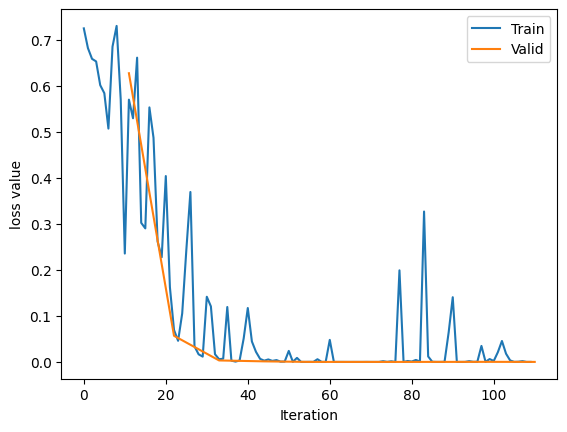

In [7]:
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
from matplotlib import pyplot as plt

# 超参数
MAX_EPOCH = 10
BATCH_SIZE = 16
LR = 0.01
log_interval = 10 #日志打印间隔
val_interval = 1

# -------------------导入数据-------------------- #
train_loader = DataLoader(dataset = train_data, batch_size = BATCH_SIZE, shuffle = True)
valid_loader = DataLoader(dataset = valid_data, batch_size = BATCH_SIZE)

# -------------------构建模型-------------------- #
net = LeNet(classes = 2)
net.initialize_weights()

# -------------------损失函数-------------------- #
criterion = nn.CrossEntropyLoss()

# -------------------优化器---------------------- #
optimizer = optim.SGD(net.parameters(), lr = LR, momentum = 0.9)  # 选择优化器
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 10, gamma = 10) # 设置学习率下降策略

# -------------------训练----------------------- #
train_curve = list()
valid_curve = list()

for epoch in range(MAX_EPOCH):

    loss_mean = 0.
    correct = 0.
    total = 0.

    net.train()
    for i, data in enumerate(train_loader):

        # forward
        inputs, labels = data
        
        ##-----------------查看输入图片--------------------
        # img_tensor = inputs[0, ...]
        # img = transform_invert(img_tensor, train_transform)
        # plt.imshow(img)
        # plt.show()
        # plt.pause(0.5)
        # plt.close()
        # break

        ### 查看FiveCrop的图片
        # bs, ncrops, c, h, w = inputs.shape
        # for n in range(ncrops):
        #     img_tensor = inputs[0, n, ...]
        #     img = transform_invert(img_tensor, train_transform)
        #     plt.imshow(img)
        #     plt.show()
        #     plt.pause(0.5)
        #     plt.close()
        
        ##---------------------------------------------------
        
        outputs = net(inputs)

        # backward
        optimizer.zero_grad()
        loss = criterion(outputs, labels)
        loss.backward()

        # update weights
        optimizer.step()

        # 统计分类情况
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).squeeze().sum().numpy()

        # 打印训练信息
        loss_mean += loss.item()
        train_curve.append(loss.item())
        if (i+1) % log_interval == 0:
            loss_mean = loss_mean / log_interval
            print("Training:Epoch[{:0>3}/{:0>3}] Iteration[{:0>3}/{:0>3}] Loss: {:.4f} Acc:{:.2%}".format(
                epoch, MAX_EPOCH, i+1, len(train_loader), loss_mean, correct / total))
            loss_mean = 0.

    scheduler.step()  # 更新学习率

    # validate the model
    if (epoch+1) % val_interval == 0:

        correct_val = 0.
        total_val = 0.
        loss_val = 0.
        net.eval()
        with torch.no_grad():
            for j, data in enumerate(valid_loader):
                inputs, labels = data
                outputs = net(inputs)
                loss = criterion(outputs, labels)

                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).squeeze().sum().numpy()

                loss_val += loss.item()

            valid_curve.append(loss_val/valid_loader.__len__())
            print("Valid:\t Epoch[{:0>3}/{:0>3}] Iteration[{:0>3}/{:0>3}] Loss: {:.4f} Acc:{:.2%}".format(
                epoch, MAX_EPOCH, j+1, len(valid_loader), loss_val, correct_val / total_val))

train_x = range(len(train_curve))
train_y = train_curve

train_iters = len(train_loader)
valid_x = np.arange(1, len(valid_curve) + 1) * train_iters * val_interval
valid_y = valid_curve

plt.plot(train_x, train_y, label = 'Train')
plt.plot(valid_x, valid_y, label = 'Valid')

plt.legend(loc = 'upper right')
plt.ylabel('loss value')
plt.xlabel('Iteration')
plt.show()

